In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc.single_pred import ADME
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
data = ADME(name = 'Clearance_Hepatocyte_AZ').get_data(format = 'dict')
X, y = data['Drug'], data['Y']

Found local copy...
Loading...
Done!


In [3]:
print(y.mean())
print(y.max())
print(y.min())
print(np.median(y))

42.90037098103874
150.0
3.0
19.0


In [4]:
X_morgan = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=1024) for smiles in X]
X_morgan_np = np.array([np.array(fp) for fp in X_morgan])
# 데이터 분할: 학습 및 테스트 세트
X_train, X_test, y_train, y_test = train_test_split(X_morgan_np, y, test_size=0.2, random_state=42)

# Cross-validation을 위한 fold 개수와 반복 횟수 설정
num_folds = 5
num_repeats = 10

# Cross-validation을 반복하여 각 반복에서의 점수를 저장할 리스트 생성
cv_mse_scores = []
cv_mape_scores = []
cv_mae_scores = []
cv_r2_scores = []

# 각 반복에서의 점수를 저장할 리스트 생성
all_mse_scores = []
all_mae_scores = []
all_mape_scores = []
all_r2_scores = []

# KFold 객체를 생성하여 데이터를 섞고 나누는 인덱스 생성
kf = KFold(n_splits=num_folds, shuffle=True)

In [5]:
# 반복적으로 cross-validation 수행
for i in range(num_repeats):
    # 모델 정의
    model = RandomForestRegressor(min_samples_leaf=4, min_samples_split=4 ,n_estimators=100, random_state=42)
    
    mse_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    mape_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_percentage_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    cv_mse_scores.append(mse_scores.mean())
    cv_mape_scores.append(mape_scores.mean())
    cv_mae_scores.append(mae_scores.mean())
    cv_r2_scores.append(r2_scores.mean())

    # 각 반복에서의 점수를 저장
    all_mse_scores.append(mse_scores)
    all_mae_scores.append(mae_scores)
    all_mape_scores.append(mape_scores)
    all_r2_scores.append(r2_scores)


In [6]:
# 각 평가 지표의 값을 파일로 저장
np.savetxt('mse_scores_clearance.txt', all_mse_scores)
np.savetxt('mae_scores_clearance.txt', all_mae_scores)
np.savetxt('mape_scores_clearance.txt', all_mape_scores)
np.savetxt('r2_scores_clearance.txt', all_r2_scores)

# Cross-validation 점수의 평균 계산
mean_mse_score = np.mean(cv_mse_scores)
mean_mae_score = np.mean(cv_mae_scores)
mean_mape_score = np.mean(cv_mape_scores)
mean_r2_score = np.mean(cv_r2_scores)

# Cross-validation 점수의 표준 편차 계산
std_dev_mse = np.std(cv_mse_scores)
std_dev_mae = np.std(cv_mae_scores)
std_dev_mape = np.std(cv_mape_scores)
std_dev_r2 = np.std(cv_r2_scores)

# 평균과 표준 편차 출력
print("평균 Cross-validation MSE:", mean_mse_score)
print("Cross-validation MSE 표준 편차:", std_dev_mse)

print("평균 Cross-validation MAE:", mean_mae_score)
print("Cross-validation MAE 표준 편차:", std_dev_mae)

print("평균 Cross-validation MAPE:", mean_mape_score)
print("Cross-validation MAPE 표준 편차:", std_dev_mape)

print("평균 Cross-validation R square:", mean_r2_score)
print("Cross-validation R square 표준 편차:", std_dev_r2)

평균 Cross-validation MSE: 2077.0703897405347
Cross-validation MSE 표준 편차: 20.047486641078716
평균 Cross-validation MAE: 33.8743680933323
Cross-validation MAE 표준 편차: 0.2527850150122194
평균 Cross-validation MAPE: 2.853418803952059
Cross-validation MAPE 표준 편차: 0.03488991791748023
평균 Cross-validation R square: 0.16966676971963496
Cross-validation R square 표준 편차: 0.006081531006677761


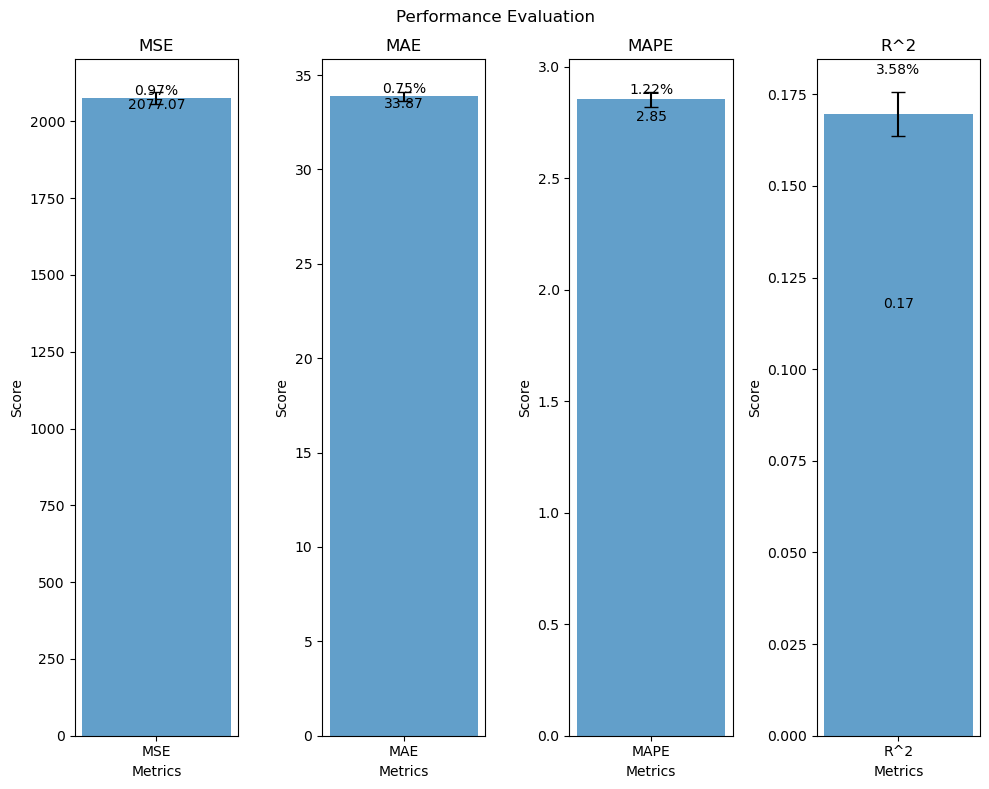

In [7]:
import matplotlib.pyplot as plt

mean_scores = [mean_mse_score, mean_mae_score, mean_mape_score, mean_r2_score]
std_devs = [std_dev_mse, std_dev_mae, std_dev_mape, std_dev_r2]

# 그래프에 표시할 평가 지표 이름
metrics = ['MSE', 'MAE', 'MAPE', 'R^2']

# 에러율 계산
error_values = [std_dev / mean_score for std_dev, mean_score in zip(std_devs, mean_scores)]

# 그래프 크기 설정
plt.figure(figsize=(10, 8))

# 4개의 subplot 생성
for i in range(4):
    plt.subplot(1, 4, i+1)
    
    # 막대 그래프 그리기
    bar = plt.bar(metrics[i], mean_scores[i], yerr=std_devs[i], capsize=5, alpha=0.7, width=0.5)
    
    # 에러율 표시
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height() + 0.01, f'{error_values[i]*100:.2f}%', ha='center', va='bottom')

    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height- 0.05, f'{height:.2f}', ha='center', va='top')
    
    # subplot의 제목 설정
    plt.title(metrics[i])
    plt.xlabel('Metrics')
    plt.ylabel('Score')

# 전체 그래프의 제목 설정
plt.suptitle('Performance Evaluation')

# 그래프 간의 간격 조절
plt.tight_layout()

# 그래프 보이기
plt.show()